# Assignment 3

# PUBG Finish Placement Prediction

## Abstract:

>In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.
>We are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post- The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.
>We will create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place).

# Data fields


>1. DBNOs - Number of enemy players knocked.<br>
>2. assists - Number of enemy players this player damaged that were killed by teammates.<br>
>3. boosts - Number of boost items used.<br>
>4. damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.<br>
>5. headshotKills - Number of enemy players killed with headshots.<br>
>6. heals - Number of healing items used.<br>
>8. Id - Player’s Id<br>
>9. killPlace - Ranking in match of number of enemy players killed.<br>
>10. killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.<br>
>11. killStreaks - Max number of enemy players killed in a short amount of time.<br>
>12. kills - Number of enemy players killed.<br>
>13. longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.<br>
>14. matchDuration - Duration of match in seconds.<br>
>15. matchId - ID to identify match. There are no matches that are in both the training and testing set.<br>
>16. matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.<br>
>17. rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.<br>
>18. revives - Number of times this player revived teammates.<br>
>19. rideDistance - Total distance traveled in vehicles measured in meters.<br>
>20. roadKills - Number of kills while in a vehicle.<br>
>21. swimDistance - Total distance traveled by swimming measured in meters.<br>
>22. teamKills - Number of times this player killed a teammate.<br>
>23. vehicleDestroys - Number of vehicles destroyed.<br>
>24. walkDistance - Total distance traveled on foot measured in meters.<br>
>25. weaponsAcquired - Number of weapons picked up.<br>
>26. winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.<br>
>27. groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.<br>
>28. numGroups - Number of groups we have data for in the match.<br>
>29. maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.<br>
>30. winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.<br>

In [1]:
# importing libraries
%matplotlib inline 
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import metrics
import gc
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error,accuracy_score, r2_score, make_scorer,log_loss
from sklearn.model_selection import KFold

In [2]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter('ignore')

In [3]:
# importing the dataset
dfmain=pd.read_csv("train_V2.csv", encoding='utf8', engine='python')

In [4]:
df=dfmain

## Exploratory  Data Analysis

In [5]:
df.isnull().values.any()

True

In [6]:
total = df.isnull().sum()[df.isnull().sum() != 0].sort_values(ascending = False)
percent = pd.Series(round(total/len(df)*100,2))
pd.concat([total, percent], axis=1, keys=['total_missing', 'percent'])

,total_missing,percent
winPlacePerc,1,0.0


In [5]:
df=df.dropna()

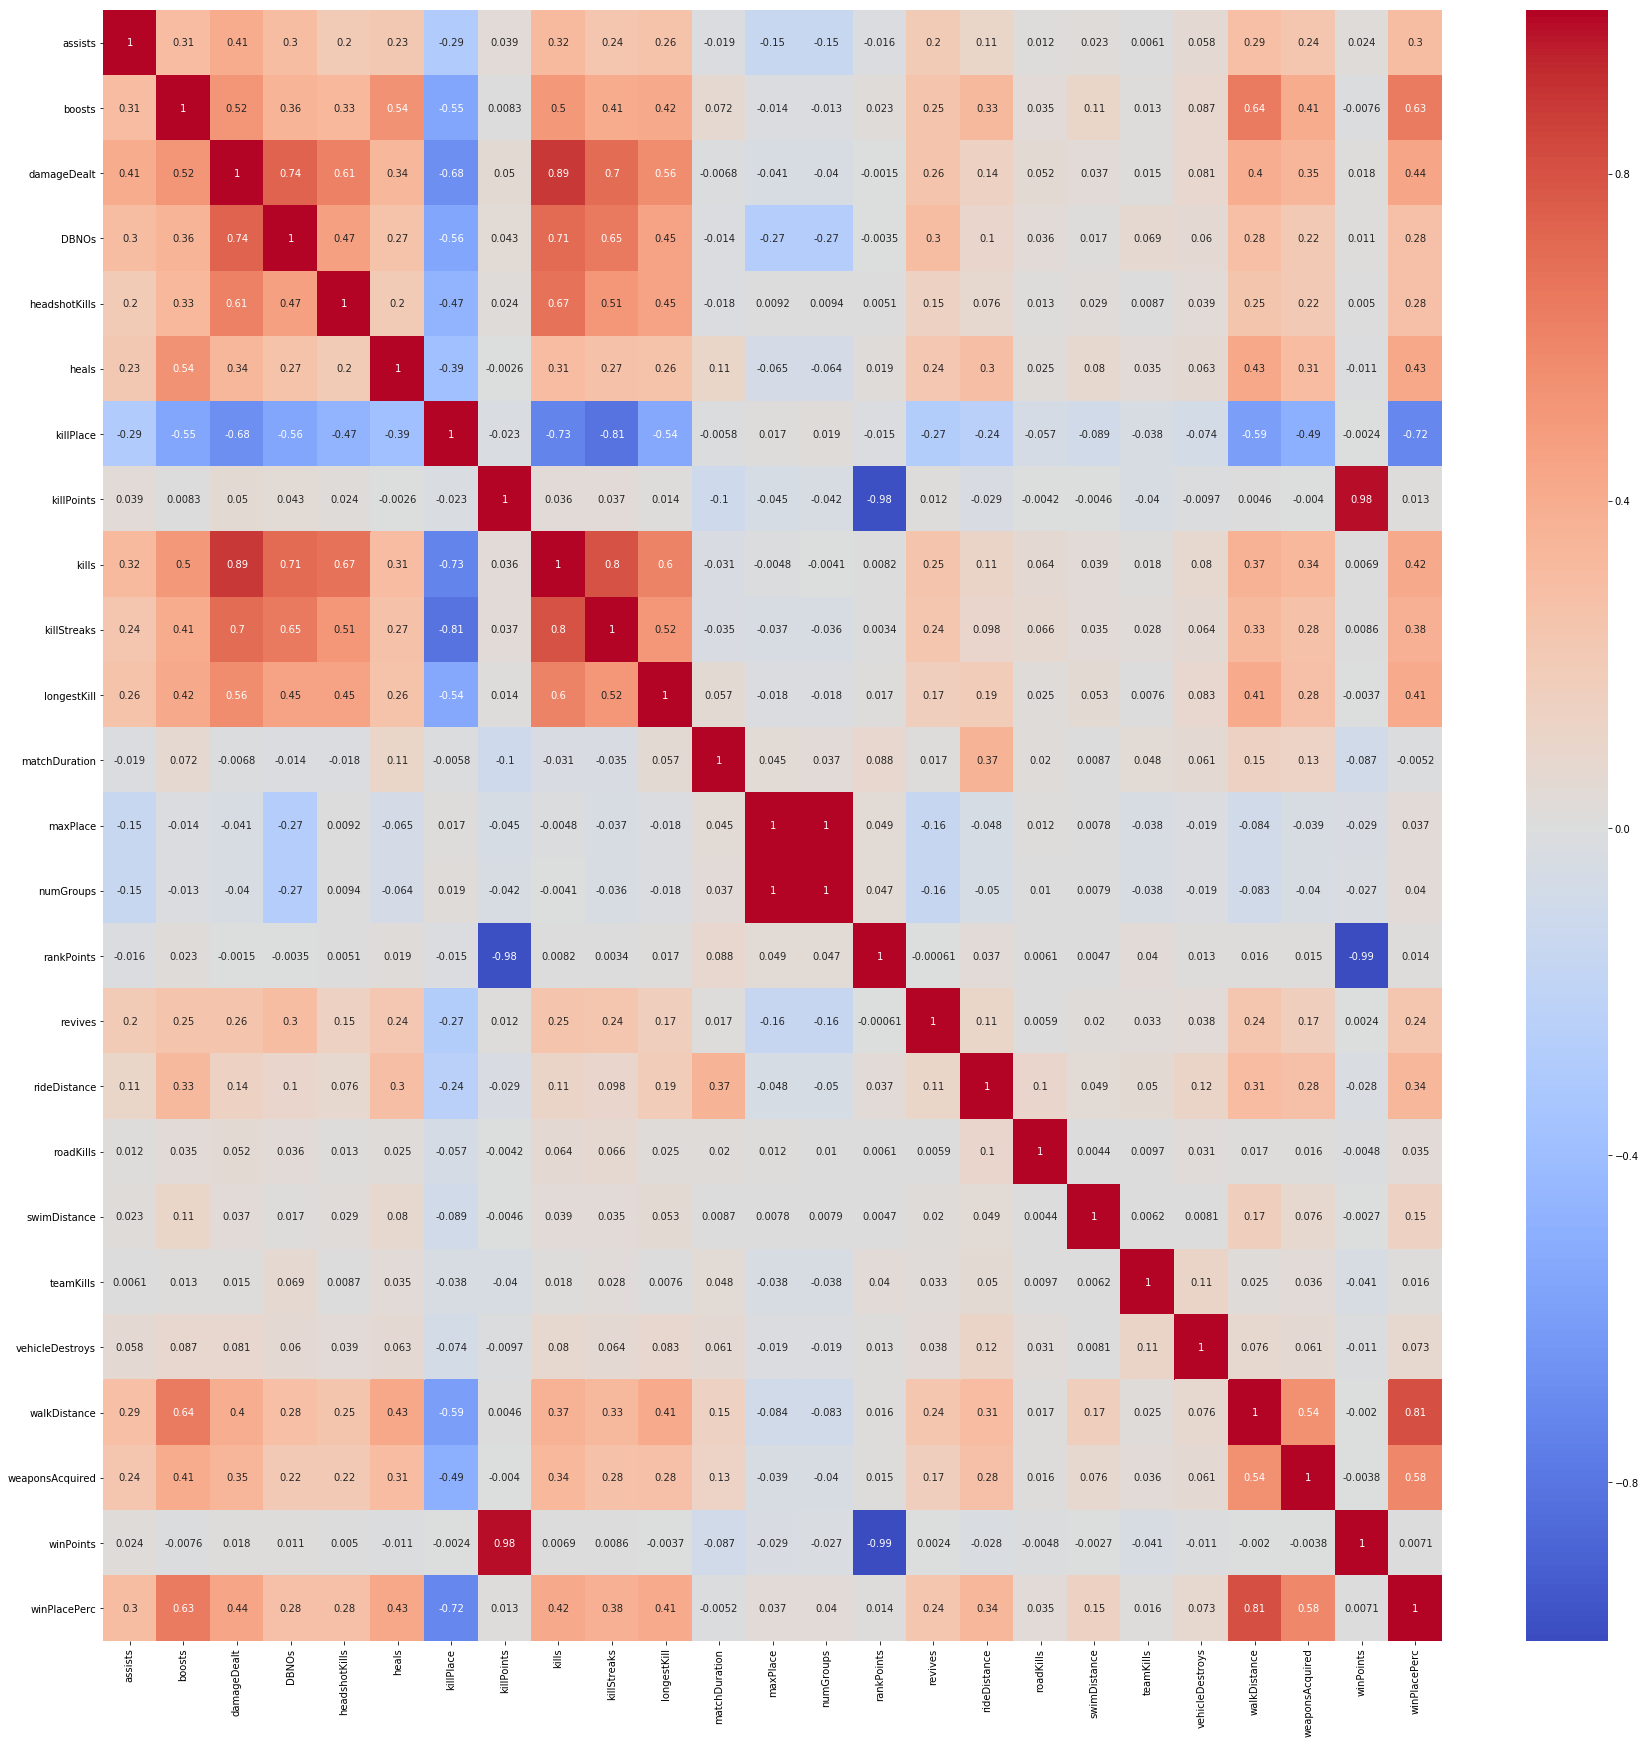

In [9]:
fig, ax = plt.subplots(figsize=(30,30))  
sns.heatmap(df.corr(),annot=True,cmap='coolwarm', ax=ax)

There is significant correlation between 'winPlacePerc' and other estimators like 'walkDistance',  'boosts',
       'weaponsAcquired', 'damageDealt', 'damageDealtNorm',
       'heals', 'kills'

# Solos, Duos and Squads

There are 3 game modes in the game. One can play solo, or with a friend (duo), or with 3 other friends (squad). 100 players join the same server, so in the case of duos the max teams are 50 and in the case of squads the max teams are 25.

In [234]:
solos = df[df['numGroups']>50]
duos = df[(df['numGroups']>25) & (df['numGroups']<=50)]
squads = df[df['numGroups']<=25]
print("There are {} ({:.2f}%) solo games, {} ({:.2f}%) duo games and {} ({:.2f}%) squad games.".format(len(solos), 100*len(solos)/len(df), len(duos), 100*len(duos)/len(df), len(squads), 100*len(squads)/len(df),))

There are 709111 (15.95%) solo games, 3295326 (74.10%) duo games and 442528 (9.95%) squad games.


# Developing New Features

A game in PUBG can have up to 100 players fighting each other. But most of the times a game isn't "full". There is no variable that gives us the number of players joined. So lets create one

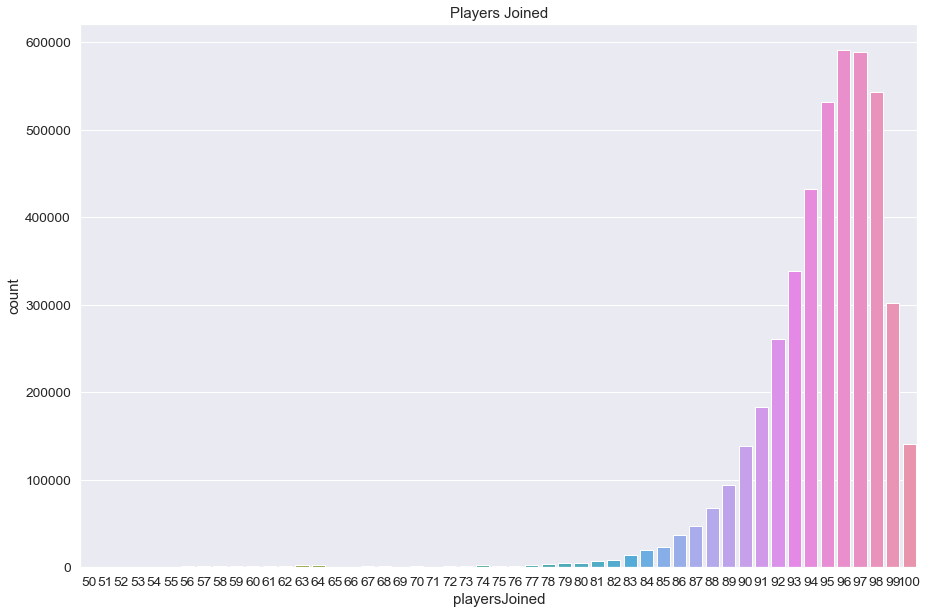

In [236]:
df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')
data = df.copy()
data = data[data['playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

Based on the "playersJoined" feature we can create (or change) a lot of others to normalize their values. For example i will create the "killsNorm" and "damageDealtNorm" features. When there are 100 players in the game it might be easier to find and kill someone, than when there are 90 players. So i will normalize the kills in a way that a kill in 100 players will score 1 (as it is) and in 90 players it will score (100-90)/100 + 1 = 1.1. This is just an assumption. You can use different scales.

In [237]:
df['killsNorm'] = df['kills']*((100-df['playersJoined'])/100 + 1)
df['damageDealtNorm'] = df['damageDealt']*((100-df['playersJoined'])/100 + 1)
df[['playersJoined', 'kills', 'killsNorm', 'damageDealt', 'damageDealtNorm']][1:10]

,playersJoined,kills,killsNorm,damageDealt,damageDealtNorm
1,91,0,0.00,91.470,99.70230
2,98,0,0.00,68.000,69.36000
3,91,0,0.00,32.900,35.86100
4,97,1,1.03,100.000,103.00000
5,95,1,1.05,100.000,105.00000
6,97,0,0.00,0.000,0.00000
7,96,0,0.00,8.538,8.87952
8,97,0,0.00,51.600,53.14800
9,97,0,0.00,37.270,38.38810


## Heals and Boosts

In [238]:
df['healsAndBoosts'] = df['heals']+df['boosts']
df['totalDistance'] = df['walkDistance']+df['rideDistance']+df['swimDistance']

When using boosting items you run faster. They also help staying out of the zone (PUBG term) and loot more (meaning walking more). So lets create a feature boosts per walking distance. Heals don't make you run faster, but they also help staying out of the zone and loot more. So lets create the same feature for heals also.

In [239]:
df['boostsPerWalkDistance'] = df['boosts']/(df['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where boosts>0 and walkDistance=0. Strange.
df['boostsPerWalkDistance'].fillna(0, inplace=True)
df['healsPerWalkDistance'] = df['heals']/(df['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where heals>0 and walkDistance=0. Strange.
df['healsPerWalkDistance'].fillna(0, inplace=True)
df['healsAndBoostsPerWalkDistance'] = df['healsAndBoosts']/(df['walkDistance']+1) #The +1 is to avoid infinity.
df['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)
df[['walkDistance', 'boosts', 'boostsPerWalkDistance' ,'heals',  'healsPerWalkDistance', 'healsAndBoosts', 'healsAndBoostsPerWalkDistance']][40:45]

,walkDistance,boosts,boostsPerWalkDistance,heals,healsPerWalkDistance,healsAndBoosts,healsAndBoostsPerWalkDistance
40,327.30,1,0.003046,1,0.003046,2,0.006092
41,128.80,0,0.000000,0,0.000000,0,0.000000
42,52.52,0,0.000000,0,0.000000,0,0.000000
43,534.10,1,0.001869,0,0.000000,1,0.001869
44,2576.00,4,0.001552,6,0.002328,10,0.003880


Same, let's create the feature "killsPerWalkDistance".

In [240]:
df['killsPerWalkDistance'] = df['kills']/(df['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where kills>0 and walkDistance=0. Strange.
df['killsPerWalkDistance'].fillna(0, inplace=True)
df[['kills', 'walkDistance', 'rideDistance', 'killsPerWalkDistance', 'winPlacePerc']].sort_values(by='killsPerWalkDistance').tail(10)

,kills,walkDistance,rideDistance,killsPerWalkDistance,winPlacePerc
4115816,29,0.0,0.0,29.0,0.7500
422093,30,0.0,0.0,30.0,1.0000
3083358,30,0.0,0.0,30.0,0.7500
3057746,31,0.0,0.0,31.0,0.7500
2394021,31,0.0,0.0,31.0,0.5385
2998470,35,0.0,0.0,35.0,1.0000
3062788,36,0.0,0.0,36.0,0.8667
1158891,36,0.0,0.0,36.0,0.5833
1068513,38,0.0,0.0,38.0,0.8333
1702541,43,0.0,0.0,43.0,1.0000


0 walking distance and many kills? Also most have winPlacePerc=1. Definitelly cheaters.
We need to drop the values where walkDistance is 0 and kills is more than 0

In [241]:
i =np.array( df[((df.walkDistance == 0.0) &( df.kills != 0)  )].index)
df=df.drop(i)
df[['kills', 'walkDistance', 'rideDistance',
    'killsPerWalkDistance', 'winPlacePerc']].sort_values(by='killsPerWalkDistance').tail(10)

,kills,walkDistance,rideDistance,killsPerWalkDistance,winPlacePerc
4181578,21,7.7590,0.0,2.397534,0.8000
3049855,13,4.2410,0.0,2.480443,0.6667
3217625,12,3.5270,0.0,2.650762,0.0000
4203303,19,6.0040,0.0,2.712736,0.4000
2445369,16,4.7380,0.0,2.788428,0.9167
2724770,11,2.8470,0.0,2.859371,0.6667
2746359,6,0.4674,0.0,4.088865,0.7857
3673965,55,12.1900,0.0,4.169826,1.0000
2724641,45,8.7770,0.0,4.602639,0.9231
3306833,17,0.3936,0.0,12.198622,0.5000


In [242]:
y =np.array( df[(df.walkDistance == 0.0)].index)
y
df=df.drop(y)

In [243]:
y =np.array( df[(df.maxPlace <0)].index)
y

array([], dtype=int64)

Earlier in the kernel we did EDA for Solos, Duos and Squads. Lets create a column for them

In [244]:
df['team'] = [1 if i>50 else 2 if (i>25 & i<=50) else 4 for i in df['numGroups']]

Developing a function to format the display for EDA

In [19]:
def featStat(featureName, constrain,plotType):
    feat = df[featureName][df[featureName]>0]
    data = df[[featureName,'winPlacePerc']].copy()
    q99 = int(data[featureName].quantile(0.99))
    plt.rcParams['figure.figsize'] = 15,5;   
    
    if constrain!=None:
        feat = feat[feat<constrain]
    if plotType == 'hist':
        plt.subplot(1,2,1)
        feat.hist(bins=50);
        plt.title(featureName);
        
        n = 20
        cut_range = np.linspace(0,q99,n)
        cut_range = np.append(cut_range, data[featureName].max())
        data[featureName] = pd.cut(data[featureName],
                                         cut_range,
                                         labels=["{:.0f}-{:.0f}".format(a_, b_) for a_, b_ in zip(cut_range[:n], cut_range[1:])],
                                         include_lowest=True
                                        )
        ax = plt.subplot(1,2,2)
        sns.boxplot(x="winPlacePerc", y=featureName, data=data, ax=ax, color="#2196F3")
        ax.set_xlabel('winPlacePerc', size=14, color="#263238")
        ax.set_ylabel(featureName, size=14, color="#263238")
        plt.gca().xaxis.grid(True)
        plt.tight_layout()
           
    if plotType == 'count':        
        plt.subplot(1,2,1)
        sns.countplot(feat, color="#2196F3");
        
        plt.subplot(1,2,2)
        data.loc[data[featureName] > q99, featureName] = q99+1
        x_order = data.groupby(featureName).mean().reset_index()[featureName]
        x_order.iloc[-1] = str(q99+1)+"+"
        data[featureName][data[featureName] == q99+1] = str(q99+1)+"+"
        
        ax = sns.boxplot(x=featureName, y='winPlacePerc', data=data, color="#2196F3", order = x_order);
        ax.set_xlabel(featureName, size=14, color="#263238")
        ax.set_ylabel('WinPlacePerc', size=14, color="#263238")
    plt.tight_layout()

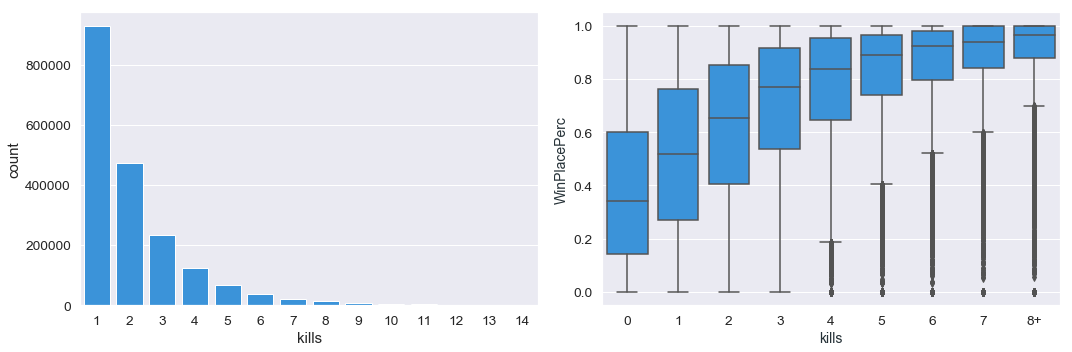

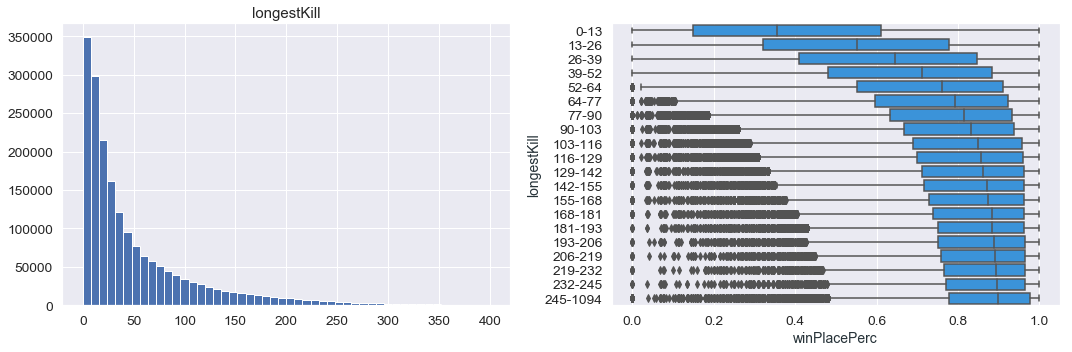

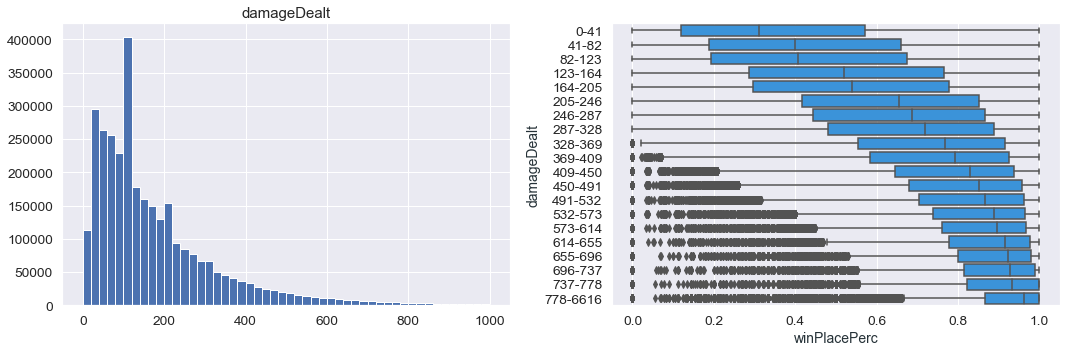

In [76]:
featStat('kills',15,'count');
plt.show();
featStat('longestKill',400,'hist');
plt.show();
featStat('damageDealt',1000,'hist');

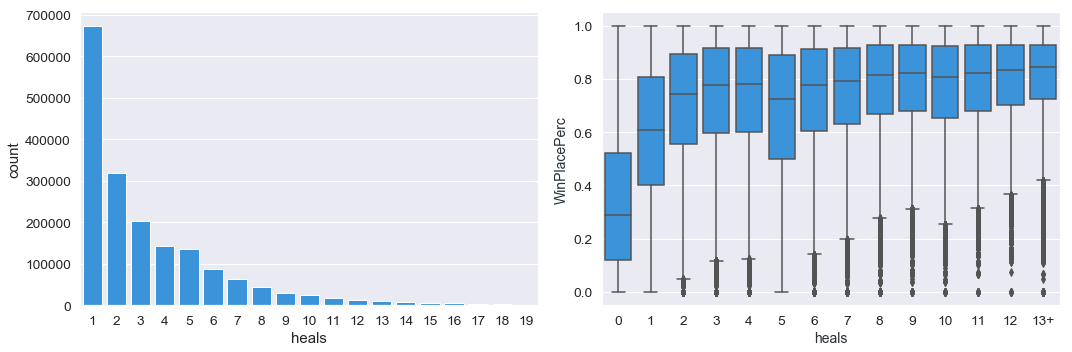

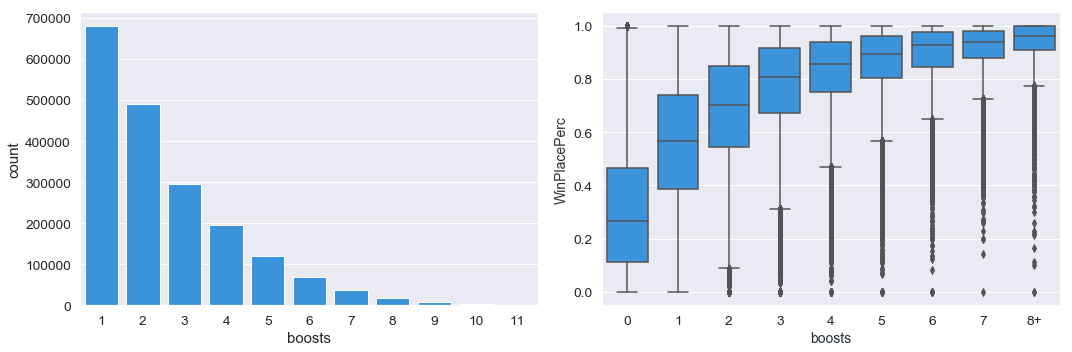

In [77]:
featStat('heals',20,'count')
plt.show()
featStat('boosts',12,'count')

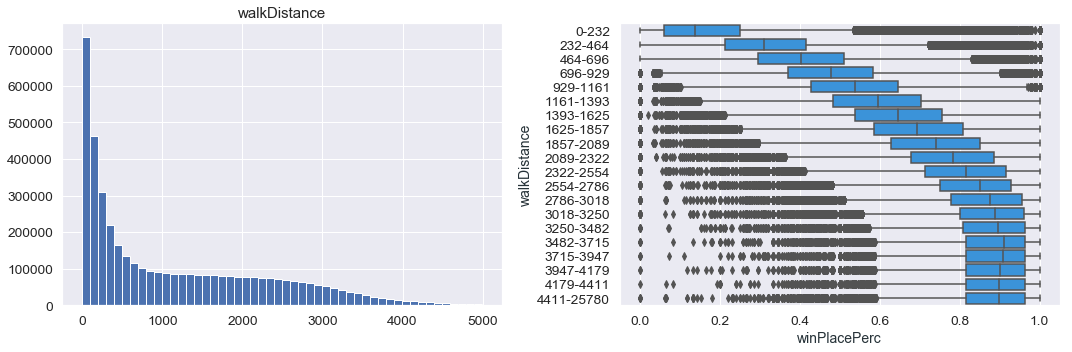

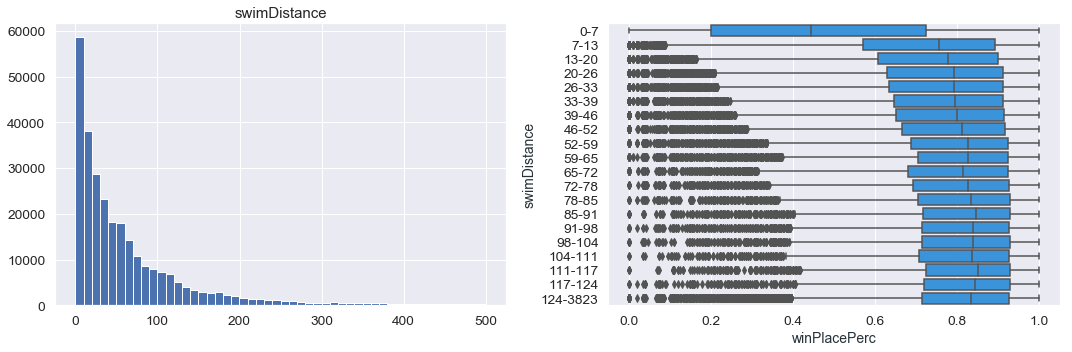

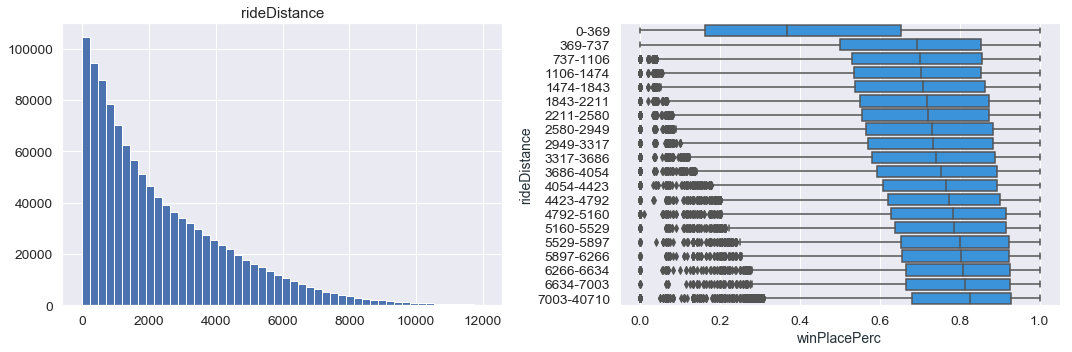

In [78]:
featStat('walkDistance',5000,'hist')
plt.show()
featStat('swimDistance',500,'hist')
plt.show()
featStat('rideDistance',12000,'hist')

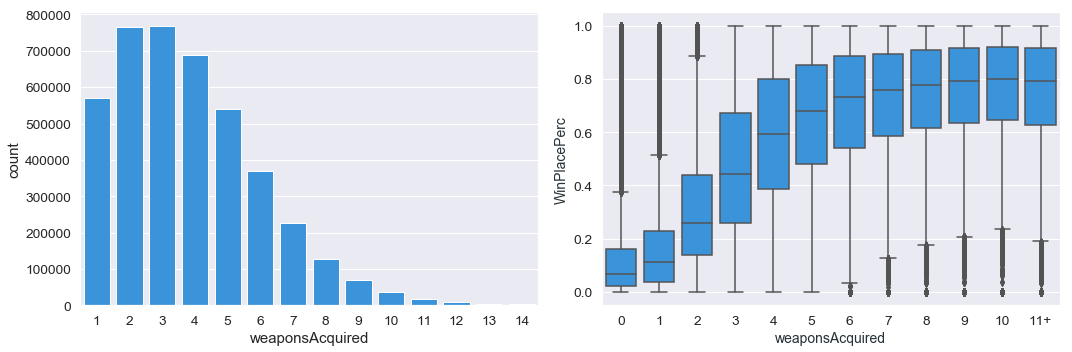

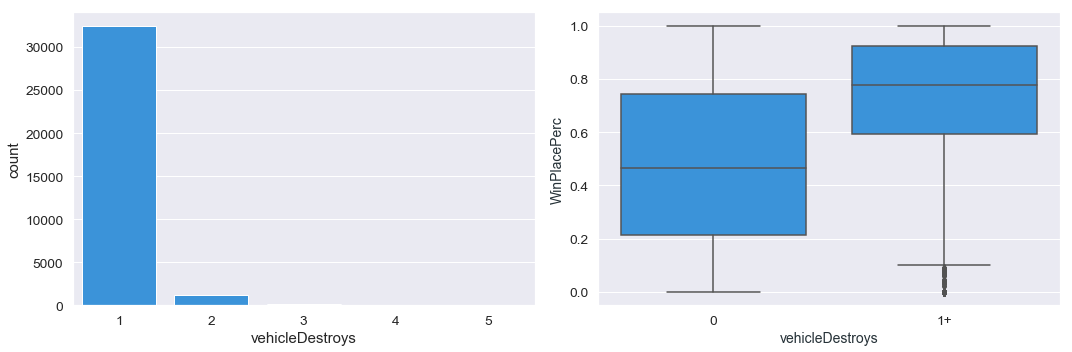

In [79]:
featStat('weaponsAcquired',15,'count')
plt.show()
featStat('vehicleDestroys',None,'count')

In [282]:
print("Number of match in train dataset:",df['matchId'].nunique())

Number of match in train dataset: 47964


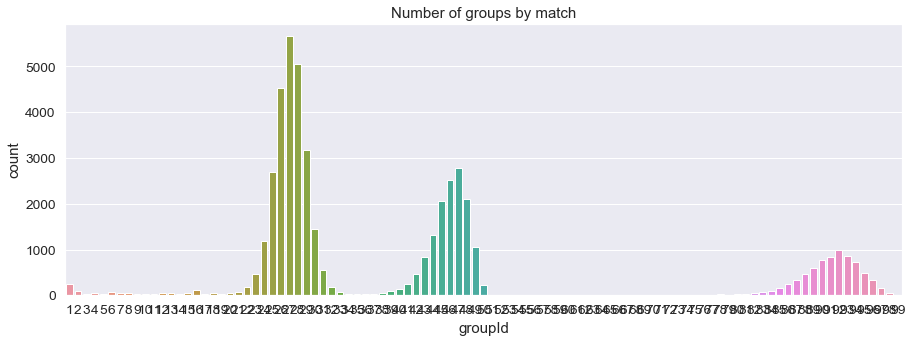

In [247]:
ngroupsByMatch = df.groupby('matchId')['groupId'].nunique()
ax = sns.countplot(ngroupsByMatch)
plt.title('Number of groups by match');
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
#ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))

In [263]:
df=df.dropna()

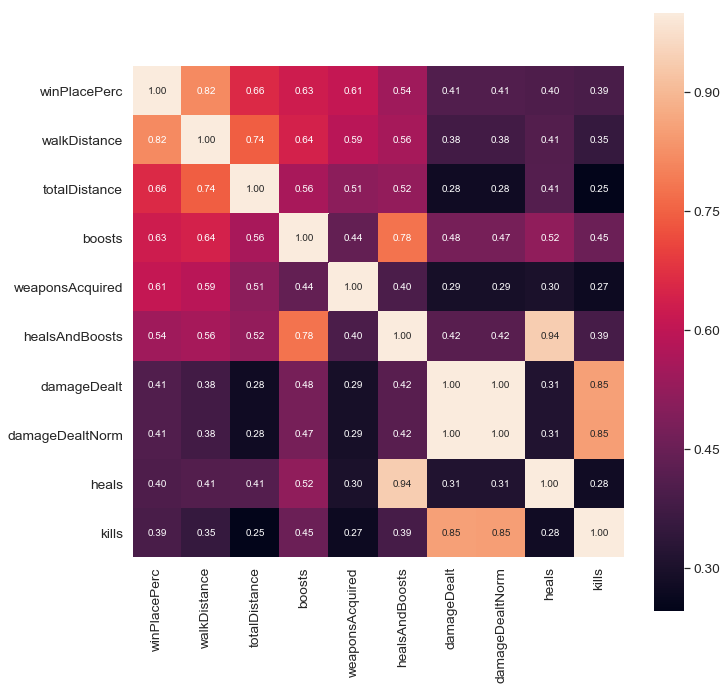

In [98]:
k = 10 #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = df.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [264]:
df=df.dropna()

## Function to aggregate some values

In [265]:
def _min(x):
    return x.value_counts().values.min()
def _max(x):
    return x.value_counts().values.max()
def _avg(x):
    return x.value_counts().values.mean()
def _med(x):
    return np.median(x.value_counts().values)
def _num(x):
    return x.nunique()
infostat = df.groupby('matchType').agg({
    "matchId": [np.size, _num, _min,_med,_max], #np.size - number of players, _num - number of matches
    "groupId": [_min,_med,_max],
    "matchDuration": [min,np.median, max], 
    "maxPlace": [min,np.median,max],
    "numGroups":[min,np.median,max]
    }).sort_values(by=('matchId','size'),ascending=False)  
display(infostat)

matchId                        groupId            \
                     size   _num _min  _med _max    _min _med _max   
matchType                                                            
squad-fpp         1603868  18576    4  87.0  100       1  3.0   27   
duo-fpp            925190  10620    7  88.0  100       1  2.0   72   
squad              566122   6658   17  86.0   99       1  3.0   26   
solo-fpp           488394   5678    7  87.0   98       1  1.0   63   
duo                287483   3356   28  87.0   98       1  2.0    9   
solo               156844   2125    1  85.0   97       1  1.0    5   
normal-squad-fpp    10255    334    1  27.0   83       1  4.0   64   
crashfpp             5976     73   19  87.0   98       1  2.0   10   
normal-duo-fpp       4372    137    1  29.0   91       1  2.0    4   
flaretpp             2146     29   43  75.0   91       1  3.0   15   
normal-solo-fpp       642     67    1   9.0   47       1  1.0    5   
flarefpp              603      9   50  70.0   86       1  3.0   16   
crashtpp              358      5   57  67.0   87       1  2.0    6   
normal-squad          206     13    1   5.0   84       1  3.0    7   
normal-duo            124      9    2  13.0   39       1  2.0    3   
normal-solo            90     15    1   1.0   28       1  1.0    2   

                 matchDuration              maxPlace             numGroups  \
                           min median   max      min median  max       min   
matchType                                                                    
squad-fpp                  728   1398  2226        2     28   37         2   
duo-fpp                    840   1424  2202        4     48   51         4   
squad                     1048   1455  2218        7     28   34         6   
solo-fpp                  1044   1437  2199        8     96  100         8   
duo                       1182   1508  2204       20     48   51        18   
solo                      1119   1536  2237       12     96  100         1   
normal-squad-fpp           246   1986  2185        2     16   27         2   
crashfpp                   829    901   924       12     49   52        12   
normal-duo-fpp             152   1896  2181        3     31   50         3   
flaretpp                  1746   1878  1981       15     26   28        15   
normal-solo-fpp            133    901  1880        2     15   54         2   
flarefpp                  1792   1889  2031       16     26   29        16   
crashtpp                   848    914   924       30     37   46        29   
normal-squad               583   1864  1957        2     15   25         2   
normal-duo                 807   1106  1793        5      8   20         4   
normal-solo                317   1587  1823        6     23   44         5   

                              
                 median  max  
matchType                     
squad-fpp            27   37  
duo-fpp              46   51  
squad                27   33  
solo-fpp             93  100  
duo                  46   50  
solo                 92   99  
normal-squad-fpp     16   25  
crashfpp             46   52  
normal-duo-fpp       31   49  
flaretpp             24   27  
normal-solo-fpp      13   51  
flarefpp             25   29  
crashtpp             33   44  
normal-squad         15   25  
normal-duo            8   20  
normal-solo          23   29

# LGB Regressor

Function to reduce memory usage

In [6]:
def reduce_mem_usage(df):
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


In [11]:
def initial_preparing(df, Debug):
    if Debug:
        df = df[df['matchId'].isin(df['matchId'].unique()[:2000])]
    # Drop next columns. *Points features don't correlate with target feature, need
    # more EDA to understand how they work.
    df.drop(columns=['teamKills','roadKills','matchDuration','killPoints','rankPoints','winPoints','matchType','maxPlace','Id'],inplace=True)
    X = df.groupby(['matchId','groupId']).agg(np.mean)
    X = reduce_mem_usage(X)
    y = X['winPlacePerc']     
    X.drop(columns=['winPlacePerc'],inplace=True)
    X_ranked = X.groupby('matchId').rank(pct=True)
    X = X.reset_index()[['matchId','groupId']].merge(X_ranked, how='left', on=['matchId', 'groupId'] )
    X.drop(['matchId','groupId'],axis=1, inplace=True)
    X = reduce_mem_usage(X)
    return X, y

In [22]:
X_train, y = initial_preparing(df.copy(),False)

Memory usage of dataframe is 309.62 MB
Memory usage after optimization is: 100.87 MB
Decreased by 67.4%
Memory usage of dataframe is 278.33 MB
Memory usage after optimization is: 81.18 MB
Decreased by 70.8%


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.2, random_state=666)

In [24]:
import lightgbm as lgb
import time as time
import gc
lgtrain = lgb.Dataset(X_train, label=y_train.reset_index(drop=True))
res = lgb.cv({'metric': 'mae'},lgtrain, nfold=5,stratified=False,seed=666)
print("Mean MAE:",res['l1-mean'][-1])
gc.collect()

Mean MAE: 0.04916260179502361


188

# Feature Engineering

In [7]:
def featureModify(isTrain):
    if isTrain:
        df=dfmain
        df = df[df['maxPlace'] > 1]
        df = reduce_mem_usage(df)
        df = df[df['winPlacePerc'].notnull()]
    else:
        df = pd.read_csv('test_V2.csv')


    df['matchType'] = df['matchType'].map({
    'crashfpp':1,
    'crashtpp':2,
    'duo':3,
    'duo-fpp':4,
    'flarefpp':5,
    'flaretpp':6,
    'normal-duo':7,
    'normal-duo-fpp':8,
    'normal-solo':9,
    'normal-solo-fpp':10,
    'normal-squad':11,
    'normal-squad-fpp':12,
    'solo':13,
    'solo-fpp':14,
    'squad':15,
    'squad-fpp':16
    })
    df = reduce_mem_usage(df)

    print("Match size")
    matchSizeData = df.groupby(['matchId']).size().reset_index(name='matchSize')
    df = pd.merge(df, matchSizeData, how='left', on=['matchId'])
    del matchSizeData
    gc.collect()
    
    
    df.loc[(df['rankPoints']==-1), 'rankPoints'] = 0
    df['_killPoints_rankpoints'] = df['rankPoints']+df['killPoints']


    df["_Kill_headshot_Ratio"] = df["kills"]/df["headshotKills"]
    df['_killStreak_Kill_ratio'] = df['killStreaks']/df['kills']
    df['_totalDistance'] = 0.25*df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    df['_killPlace_MaxPlace_Ratio'] = df['killPlace'] / df['maxPlace']
    df['_totalDistance_weaponsAcq_Ratio'] = df['_totalDistance'] / df['weaponsAcquired']
    df['_walkDistance_heals_Ratio'] = df['walkDistance'] / df['heals']
    df['_walkDistance_kills_Ratio'] = df['walkDistance'] / df['kills']
    df['_kills_walkDistance_Ratio'] = df['kills'] / df['walkDistance']
    df['_totalDistancePerDuration'] =  df["_totalDistance"]/df["matchDuration"]
    df['_killPlace_kills_Ratio'] = df['killPlace']/df['kills']
    df['_walkDistancePerDuration'] =  df["walkDistance"]/df["matchDuration"]
    df['walkDistancePerc'] = df.groupby('matchId')['walkDistance'].rank(pct=True).values
    df['killPerc'] = df.groupby('matchId')['kills'].rank(pct=True).values
    df['killPlacePerc'] = df.groupby('matchId')['killPlace'].rank(pct=True).values
    df['weaponsAcquired'] = df.groupby('matchId')['weaponsAcquired'].rank(pct=True).values
    df['_walkDistance_kills_Ratio2'] = df['walkDistancePerc'] / df['killPerc']
    df['_kill_kills_Ratio2'] = df['killPerc']/df['walkDistancePerc']
    df['_killPlace_walkDistance_Ratio2'] = df['walkDistancePerc']/df['killPlacePerc']
    df['_killPlace_kills_Ratio2'] = df['killPlacePerc']/df['killPerc']
    df['_totalDistance'] = df.groupby('matchId')['_totalDistance'].rank(pct=True).values
    df['_walkDistance_kills_Ratio3'] = df['walkDistancePerc'] / df['kills']
    df['_walkDistance_kills_Ratio4'] = df['kills'] / df['walkDistancePerc']
    df['_walkDistance_kills_Ratio5'] = df['killPerc'] / df['walkDistance']
    df['_walkDistance_kills_Ratio6'] = df['walkDistance'] / df['killPerc']

    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    df.fillna(0, inplace=True)
    
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchSize")
    features.remove("matchType")
    if isTrain:
        features.remove("winPlacePerc")

    
    print("Mean Data")
    meanData = df.groupby(['matchId','groupId'])[features].agg('mean')
    meanData = reduce_mem_usage(meanData)
    meanData = meanData.replace([np.inf, np.NINF,np.nan], 0)
    meanDataRank = meanData.groupby('matchId')[features].rank(pct=True).reset_index()
    meanDataRank = reduce_mem_usage(meanDataRank)
    df = pd.merge(df, meanData.reset_index(), suffixes=["", "_mean"], how='left', on=['matchId', 'groupId'])
    del meanData
    gc.collect()
    df = df.drop(["vehicleDestroys_mean","rideDistance_mean","roadKills_mean","rankPoints_mean"], axis=1)
    df = pd.merge(df, meanDataRank, suffixes=["", "_meanRank"], how='left', on=['matchId', 'groupId'])
    del meanDataRank
    gc.collect()
    df = df.drop(["numGroups_meanRank","rankPoints_meanRank"], axis=1)
    
    df = df.join(reduce_mem_usage(df.groupby('matchId')[features].rank(ascending=False).add_suffix('_rankPlace').astype(int)))

    
    print("Std Data")
    stdData = df.groupby(['matchId','groupId'])[features].agg('std').replace([np.inf, np.NINF,np.nan], 0)
    stdDataRank = reduce_mem_usage(stdData.groupby('matchId')[features].rank(pct=True)).reset_index()
    del stdData
    gc.collect()
    df = pd.merge(df, stdDataRank, suffixes=["", "_stdRank"], how='left', on=['matchId', 'groupId'])
    del stdDataRank
    gc.collect()
    
    print("Max Data")
    maxData = df.groupby(['matchId','groupId'])[features].agg('max')
    maxData = reduce_mem_usage(maxData)
    maxDataRank = maxData.groupby('matchId')[features].rank(pct=True).reset_index()
    maxDataRank = reduce_mem_usage(maxDataRank)
    df = pd.merge(df, maxData.reset_index(), suffixes=["", "_max"], how='left', on=['matchId', 'groupId'])
    del maxData
    gc.collect()
    df = df.drop(["assists_max","killPoints_max","headshotKills_max","numGroups_max","revives_max","teamKills_max","roadKills_max","vehicleDestroys_max"], axis=1)
    df = pd.merge(df, maxDataRank, suffixes=["", "_maxRank"], how='left', on=['matchId', 'groupId'])
    del maxDataRank
    gc.collect()
    df = df.drop(["roadKills_maxRank","matchDuration_maxRank","maxPlace_maxRank","numGroups_maxRank"], axis=1)


    print("Min Data")
    minData = df.groupby(['matchId','groupId'])[features].agg('min')
    minData = reduce_mem_usage(minData)
    minDataRank = minData.groupby('matchId')[features].rank(pct=True).reset_index()
    minDataRank = reduce_mem_usage(minDataRank)
    df = pd.merge(df, minData.reset_index(), suffixes=["", "_min"], how='left', on=['matchId', 'groupId'])
    del minData
    gc.collect()
    df = df.drop(["heals_min","killStreaks_min","killPoints_min","maxPlace_min","revives_min","headshotKills_min","weaponsAcquired_min","_walkDistance_kills_Ratio_min","rankPoints_min","matchDuration_min","teamKills_min","numGroups_min","assists_min","roadKills_min","vehicleDestroys_min"], axis=1)
    df = pd.merge(df, minDataRank, suffixes=["", "_minRank"], how='left', on=['matchId', 'groupId'])
    del minDataRank
    gc.collect()
    df = df.drop(["killPoints_minRank","matchDuration_minRank","maxPlace_minRank","numGroups_minRank"], axis=1)

    
    print("group Size")
    groupSize = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    groupSize = reduce_mem_usage(groupSize)
    df = pd.merge(df, groupSize, how='left', on=['matchId', 'groupId'])
    del groupSize
    gc.collect()

    
    print("Match Mean")
    matchMeanFeatures = features
    matchMeanFeatures = [ v for v in matchMeanFeatures if v not in ["killPlacePerc","matchDuration","maxPlace","numGroups"] ]
    matchMeanData= reduce_mem_usage(df.groupby(['matchId'])[matchMeanFeatures].transform('mean')).replace([np.inf, np.NINF,np.nan], 0)
    df = pd.concat([df,matchMeanData.add_suffix('_matchMean')],axis=1)
    del matchMeanData,matchMeanFeatures
    gc.collect()

    print("matchMax")
    matchMaxFeatures = ["walkDistance","kills","_walkDistance_kills_Ratio","_kill_kills_Ratio2"]
    df = pd.merge(df, reduce_mem_usage(df.groupby(['matchId'])[matchMaxFeatures].agg('max')).reset_index(), suffixes=["", "_matchMax"], how='left', on=['matchId'])

    print("match STD")
    matchMaxFeatures = ["kills","_walkDistance_kills_Ratio2","_walkDistance_kills_Ratio","killPerc","_kills_walkDistance_Ratio"]
    df = pd.merge(df, reduce_mem_usage(df.groupby(['matchId'])[matchMaxFeatures].agg('std')).reset_index().replace([np.inf, np.NINF,np.nan], 0), suffixes=["", "_matchSTD"], how='left', on=['matchId'])


    df = df.drop(["Id","groupId"], axis=1)
    df = df.drop(["DBNOs","assists","headshotKills","heals","killPoints","_killStreak_Kill_ratio","killStreaks","longestKill","revives","roadKills","teamKills","vehicleDestroys","_walkDistance_kills_Ratio","weaponsAcquired"], axis=1)
    df = df.drop(["_walkDistance_heals_Ratio","_totalDistancePerDuration","_killPlace_kills_Ratio","_totalDistance_weaponsAcq_Ratio","_killPlace_MaxPlace_Ratio","_walkDistancePerDuration","rankPoints","rideDistance","boosts","winPoints","swimDistance","_kills_walkDistance_Ratio"], axis=1)
    df = df.drop(["_Kill_headshot_Ratio","maxPlace","_totalDistance","numGroups","walkDistance","killPlace"], axis=1)
    df = reduce_mem_usage(df)
    gc.collect()
    
    print("done")
    features_label = df.columns
    features_label = features_label.drop('matchId')
    if isTrain:
        features_label = features_label.drop('winPlacePerc')

    gc.collect()
    return df,features_label


In [8]:
X_train,features_label = featureModify(True)

Memory usage of dataframe is 1017.83 MB
Memory usage after optimization is: 322.31 MB
Decreased by 68.3%
Memory usage of dataframe is 322.31 MB
Memory usage after optimization is: 292.63 MB
Decreased by 9.2%
Match size
Mean Data
Memory usage of dataframe is 642.07 MB
Memory usage after optimization is: 216.85 MB
Decreased by 66.2%
Memory usage of dataframe is 757.68 MB
Memory usage after optimization is: 212.61 MB
Decreased by 71.9%
Memory usage of dataframe is 831.23 MB
Memory usage after optimization is: 233.25 MB
Decreased by 71.9%
Std Data
Memory usage of dataframe is 758.04 MB
Memory usage after optimization is: 212.98 MB
Decreased by 71.9%
Max Data
Memory usage of dataframe is 394.67 MB
Memory usage after optimization is: 189.79 MB
Decreased by 51.9%
Memory usage of dataframe is 757.68 MB
Memory usage after optimization is: 212.61 MB
Decreased by 71.9%
Min Data
Memory usage of dataframe is 394.67 MB
Memory usage after optimization is: 189.79 MB
Decreased by 51.9%
Memory usage of 

Generating a function to split the data

In [9]:
def split_train_val(data, fraction):
    matchIds = data['matchId'].unique().reshape([-1])
    train_size = int(len(matchIds)*fraction)
    
    random_idx = np.random.RandomState(seed=2).permutation(len(matchIds))
    train_matchIds = matchIds[random_idx[:train_size]]
    val_matchIds = matchIds[random_idx[train_size:]]
    
    data_train = data.loc[data['matchId'].isin(train_matchIds)]
    data_val = data.loc[data['matchId'].isin(val_matchIds)]
    
    return data_train, data_val

In [10]:
# Split the Data by matchId. Thanks to Ivan Batalov for this. 
X_train, X_train_test = split_train_val(X_train, 0.91)
print("Y time")
y = X_train['winPlacePerc']
y_test = X_train_test['winPlacePerc']
print("X_train time")
X_train = X_train.drop(columns=['matchId', 'winPlacePerc'])
print("X test train time")
X_train_test = X_train_test.drop(columns='matchId')
print("X test train winPlace remove")
X_train_test = X_train_test.drop(columns='winPlacePerc')

print("X test np time")
X_train_test = np.array(X_train_test)
print("y test np time")
y_test = np.array(y_test)

Y time
X_train time
X test train time
X test train winPlace remove
X test np time
y test np time


##### Split the Data again and then join it. I am doing this because If I turn the Pandas DataFrame into Numpy Array with  all rows at once, Kernel will be killed for exceeding 16GB Memory. 

In [11]:

from sklearn.model_selection import train_test_split
X_train, X_train2, y, y2 = train_test_split(X_train, y, test_size=0.1, shuffle=False)
print("X_train np time")
X_train = np.array(X_train)
print("y np time")
y = np.array(y)

print("X_train2 np time")
X_train2 = np.array(X_train2)
print("y2 np time")
y2 = np.array(y2)

y = np.concatenate((y, y2), axis=0)
del y2
gc.collect()
X_train = np.concatenate((X_train, X_train2), axis=0)
del X_train2
gc.collect()

X_train np time
y np time
X_train2 np time
y2 np time


0

In [12]:
train_set = lgb.Dataset(X_train, label=y)

valid_set = lgb.Dataset(X_train_test, label=y_test)
del X_train_test,y_test
gc.collect()


0

In [13]:
params = {
        "objective" : "regression", 
        "metric" : "mae", 
        "num_leaves" : 15, 
        "learning_rate" : 0.3, 
      #  "bagging_fraction" : 0.9,
       # "bagging_seed" : 0, 
        "num_threads" : 4,
        #"colsample_bytree" : 0.5,
        #'min_data_in_leaf':1900, 
        #'min_split_gain':0.00011,
        'lambda_l2':0.01
}
model = lgb.train(  params, 
                    train_set = train_set,
                    num_boost_round=4600,
                    early_stopping_rounds=10,
                    verbose_eval=100, 
                    valid_sets=[train_set,valid_set]
                  )


Training until validation scores don't improve for 10 rounds.
[100]	training's l1: 0.02774	valid_1's l1: 0.0277951
[200]	training's l1: 0.02619	valid_1's l1: 0.0263943
[300]	training's l1: 0.0253342	valid_1's l1: 0.0256479
[400]	training's l1: 0.024755	valid_1's l1: 0.0252042
[500]	training's l1: 0.024273	valid_1's l1: 0.0248429
[600]	training's l1: 0.0238974	valid_1's l1: 0.0245885
[700]	training's l1: 0.0235911	valid_1's l1: 0.0244076
[800]	training's l1: 0.0233072	valid_1's l1: 0.0242316
[900]	training's l1: 0.0230576	valid_1's l1: 0.0241014
[1000]	training's l1: 0.0228488	valid_1's l1: 0.0240139
[1100]	training's l1: 0.0226395	valid_1's l1: 0.0239142
[1200]	training's l1: 0.0224407	valid_1's l1: 0.0238344
[1300]	training's l1: 0.0222732	valid_1's l1: 0.0237801
[1400]	training's l1: 0.0221068	valid_1's l1: 0.0237121
[1500]	training's l1: 0.0219628	valid_1's l1: 0.0236617
[1600]	training's l1: 0.0217992	valid_1's l1: 0.0236052
Early stopping, best iteration is:
[1621]	training's l1: 

In [14]:
X_test,features_label = featureModify(False) 
X_test = X_test.drop(columns=['matchId'])
X_test = np.array(X_test)
y_pred=model.predict(X_test, num_iteration=model.best_iteration)
del X_test
gc.collect()

Memory usage of dataframe is 413.18 MB
Memory usage after optimization is: 108.83 MB
Decreased by 73.7%
Match size
Mean Data
Memory usage of dataframe is 279.07 MB
Memory usage after optimization is: 91.44 MB
Decreased by 67.2%
Memory usage of dataframe is 331.31 MB
Memory usage after optimization is: 92.97 MB
Decreased by 71.9%
Memory usage of dataframe is 361.54 MB
Memory usage after optimization is: 101.45 MB
Decreased by 71.9%
Std Data
Memory usage of dataframe is 329.78 MB
Memory usage after optimization is: 91.44 MB
Decreased by 72.3%
Max Data
Memory usage of dataframe is 170.88 MB
Memory usage after optimization is: 79.60 MB
Decreased by 53.4%
Memory usage of dataframe is 331.31 MB
Memory usage after optimization is: 92.97 MB
Decreased by 71.9%
Min Data
Memory usage of dataframe is 170.88 MB
Memory usage after optimization is: 79.60 MB
Decreased by 53.4%
Memory usage of dataframe is 331.31 MB
Memory usage after optimization is: 92.97 MB
Decreased by 71.9%
group Size
Memory usage

26

# Insert ID and Predictions into dataframe

In [23]:

df_sub = pd.DataFrame()

df_test = pd.read_csv('test_V2.csv')
df_test = reduce_mem_usage(df_test)
df_sub['Id'] = df_test['Id']
df_sub['winPlacePerc'] = y_pred

print(df_sub['winPlacePerc'].describe())


df_sub = df_sub.merge(df_test[["Id", "matchId", "groupId", "maxPlace", "numGroups"]], on="Id", how="left")
df_sub_group = df_sub.groupby(["matchId", "groupId"]).first().reset_index()
df_sub_group["rank"] = df_sub_group.groupby(["matchId"])["winPlacePerc"].rank()
df_sub_group = df_sub_group.merge(
    df_sub_group.groupby("matchId")["rank"].max().to_frame("max_rank").reset_index(), 
    on="matchId", how="left")
df_sub_group["adjusted_perc"] = (df_sub_group["rank"] - 1) / (df_sub_group["numGroups"] - 1)
df_sub = df_sub.merge(df_sub_group[["adjusted_perc", "matchId", "groupId"]], on=["matchId", "groupId"], how="left")
df_sub["winPlacePerc"] = df_sub["adjusted_perc"]


df_sub.loc[df_sub.maxPlace == 0, "winPlacePerc"] = 0
df_sub.loc[df_sub.maxPlace == 1, "winPlacePerc"] = 1
subset = df_sub.loc[df_sub.maxPlace > 1]
gap = 1.0 / (subset.maxPlace.values - 1)
new_perc = np.around(subset.winPlacePerc.values / gap) * gap
df_sub.loc[df_sub.maxPlace > 1, "winPlacePerc"] = new_perc
# Edge case
df_sub.loc[(df_sub.maxPlace > 1) & (df_sub.numGroups == 1), "winPlacePerc"] = 0
assert df_sub["winPlacePerc"].isnull().sum() == 0

df_sub[["Id", "winPlacePerc"]].to_csv("submission.csv", index=False)
print(df_sub['winPlacePerc'].describe())

Memory usage of dataframe is 413.18 MB
Memory usage after optimization is: 121.74 MB
Decreased by 70.5%
count    1.934174e+06
mean     4.731653e-01
std      3.051716e-01
min     -1.391976e-01
25%      2.013113e-01
50%      4.587844e-01
75%      7.441133e-01
max      1.191378e+00
Name: winPlacePerc, dtype: float64
count    1.934174e+06
mean     4.733629e-01
std      3.067983e-01
min      0.000000e+00
25%      2.000000e-01
50%      4.583333e-01
75%      7.391304e-01
max      1.000000e+00
Name: winPlacePerc, dtype: float64


# Summary

>We have referred various kernals for this kaggle competiton, and we have tried to gather the best from other kernals. We have made some changes in predicting model by changing the values for parameters. We have also implemented feature engineering to introduce some new possible features which might affect the model.

# Conclusion

>We have generated a prediction model using Light GBM. In order to achieve this , we performed necessary Exploratory Data Analysis. The predicted values for the Test.csv file were submitted in the respective Kaggle competiton where we could achieve mean absolute error of 0.02008

https://www.kaggle.com/mihirsawant/pubg-17695?scriptVersionId=12450657


![title](Capture.JPG)

# Contributions

>1. Performed feature engineering to introduce new features into the model to check if they were important estimators for model or not.<br>
>2. Created function to perform EDA.
>3. Implemented the idea of first checking the accuracy of model by cross validation and then actually training the model by setting the values for parameters as LGBM consumes a lot of time 

# Citations

>   https://www.kaggle.com/c/pubg-finish-placement-prediction/data<br>
>   https://www.kaggle.com/kamalchhirang/5th-place-solution-0-0184-score<br>
>   https://www.kaggle.com/jkraju/1st-place-solution<br>
>   https://lightgbm.readthedocs.io/en/latest/<br>
>   https://github.com/Microsoft/LightGBM<br>
>   https://www.youtube.com/watch?v=V5158Oug4W8<br>
>   https://www.youtube.com/watch?v=CzdSvJJaA-E<br>

# License

Copyright 2019 Mihir Sawant

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE